### Махова Анастасия

## Лабораторная работа 2

------------

### PART 1

$(B^d, B^f, S, X)$ -  Black Scholes cross-curency market:
* $B^d$ - domestic money market account
* $B^f$ - foreign money market account
* $S$ - foreign stock
* $X$ - rate to exchange one unit of foreign currency into domestic currency.

$$dB^d_t  = r^d B^d_t dt$$
$$dB^f_t  = r^f B^f_t dt$$
$$\frac{dS_t}{S_t} = \mu_S dt + \sigma_S dW_t^S$$
$$\frac{dX_t}{X_t} = \mu_X dt + \sigma_X dW_t^X$$
$$ d<W^S, W^X>_t = \rho dt $$

a quanto-compo forward contract paying at $T>0$ an amount given by $S_TX_{T-\tau} - K, \quad 0<\tau<T$

>Compute the par strike $K$ at $t = 0$

---------------

$$PV_t^{Quanto} = e^{-r_d(T-t)} \mathbb{E}_t^{\mathbb{Q} ^d}(S_TX_{T-\tau} - K)$$

$$PV_0^{Quanto} = 0 = e^{-r_d T} \mathbb{E}_0^{\mathbb{Q} ^d}(S_TX_{T-\tau} - K)$$

$$0 = \mathbb{E}_0^{\mathbb{Q} ^d}(S_TX_{T-\tau} - K) \quad \Rightarrow \quad K = \mathbb{E}_0^{\mathbb{Q} ^d}(S_TX_{T-\tau})$$






$\tilde B_t^{f} := X_t*B_t^f $ -- foreign money market account in domestic currency
$$d\tilde B_t^{f} = X_tdB_t^f + B_t^fdX_t + dX_tdB_t^f  = X_t r^f B^f_t dt + B_t^f\mu_X X_t dt + B_t^f\sigma_X X_tdW_t^X + 0 $$
$$d\tilde B_t^{f} =(r^f+ \mu_X)X_t  B^f_t  dt +  \sigma_X X_t B_t^f dW_t^X = (r^f+ \mu_X)\tilde B_t^f dt + \sigma_X \tilde B_t^f dW_t^X$$


$\mathbb{Q} ^d$ -- measure, where $B_t^d$ is the numerare. As $\tilde W_t$ -- brownian motion under $\mathbb{Q} ^d$, we have:

$$d\tilde B_t^{f} = r^d\tilde B_t^f dt + \sigma_X \tilde B_t^f d\tilde W_t^X$$
$$ \frac{dX_t}{X_t} = (r^d-r^f) dt + \sigma_X d\tilde W_t^X$$
$$ \frac{dS_t}{S_t} = (r^f - \rho \sigma_X \sigma_S) dt + \sigma_S d\tilde W_t^S$$

$ Y_t:= S_t X_{t-\tau}$
$$dY_t = S_t dX_{t-\tau}+ X_{t-\tau}dS_t + dS_tdX_{t-\tau} = (r^d-r^f)X_{t-\tau}S_t d(t-\tau) + \sigma_X X_{t-\tau}S_td\tilde W_{t-\tau}^X + (r^f - \rho \sigma_X \sigma_S)X_{t-\tau} S_t dt + \sigma_SX_{t-\tau} S_t d\tilde W_t^S + 0$$
$$dY_t =(r^d - \rho \sigma_X \sigma_S)Y_t dt + \sigma_X Y_t d\tilde W_{t-\tau}^X +  \sigma_S Y_t d\tilde W_t^S$$

Finally, $\mathbb{E}_0^{\mathbb{Q} ^d}(S_TX_{T-\tau}) = \mathbb{E}_0^{\mathbb{Q} ^d}(Y_T) = Y_0 e^{(r^d - \rho \sigma_X \sigma_S)T}$

Suppose, we know the historical data, so $S_0$ and $X_{-\tau}$ are defined.

___Answer:___ $K = S_0X_{-\tau} e^{(r^d - \rho \sigma_X \sigma_S)T}$

----

### PART 2

In [21]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import newton, brentq
import math
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [22]:
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar

#### 1. Build SOFR curve using OIS market quotes

OIS specifications:
* Compounded SOFR vs Fix
* Single period swaps for maturities <= 1Y. Annual payment frequency for long maturities (>1Y) 
* Day Count Convention = Act360
* Calendar = NewYork (US calendar)
* Swap start date = value date (t=0) + 2 NY business days, Period end date = period start date + period length (frequency)
* Rolling convention = Following (if period end date is a holiday then move to the next business day)
* Payment lag = 2bd in NY calendar (so payment date = period end date + 2bd)

Interpolation:
* Linear interpolation on log DF

Value date:  31.01.22



In [23]:
OIS_code = ["SOFR_1M", "SOFR_2M", "SOFR_3M", "SOFR_4M", "SOFR_5M", "SOFR_6M", "SOFR_7M", "SOFR_8M", "SOFR_9M", 
       "SOFR_10M", "SOFR_11M", "SOFR_1Y", "SOFR_2Y", "SOFR_3Y", "SOFR_4Y", "SOFR_5Y", "SOFR_6Y", "SOFR_7Y", 
       "SOFR_8Y", "SOFR_9Y", "SOFR_10Y", "SOFR_12Y", "SOFR_15Y", "SOFR_20Y", "SOFR_25Y", "SOFR_30Y"]
Quote = np.array([0.0240, 0.1070, 0.2030, 0.2860, 0.3690, 0.4330, 0.4930, 0.5580, 0.6120, 0.6630, 0.7190, 0.7650, 1.1690, 
          1.3380, 1.4170, 1.4680, 1.5070, 1.5390, 1.5640, 1.5830, 1.6040, 1.6450, 1.6860, 1.7140, 1.6950, 1.6640])/100

value_date = datetime(2022, 1, 31)

* $DF_{SOFR}(0, T) = P_d(0, T)$ - we have to find it
* $R(t, T)$ - compounded rate
* $F(0, T_{i-1}, T_i) = \frac{1}{\tau_i}\left[\frac{P_d(0, T_{i-1})}{P_d(0, T_i)} - 1\right]$
* $\tau_i = T_i - T_{i-1}$
* $\tau = 2$ bd


$$\text{PV}_t^{\text{Swap}} = \sum_{i=1}^n P_d(t, T_i+\tau) \cdot \mathbb{E}_t^{(T_i+\tau)^d} \left[ \left( R(T_{i-1}, T_i) - K \right) \tau_i \right] \\
\approx \sum_{i=1}^n P_d(t, T_i + \tau) \cdot \mathbb{E}_t^{(T_i)^d} \left[ \left( R(T_{i-1}, T_i) - K \right) \tau_i \right] \\ = \underbrace{\sum_{i=1}^n P_d(t, T_i + \tau) F(t, T_{i-1}, T_i) \tau_i}_{\text{Floating leg value}} - \underbrace{\sum_{i=1}^n P_d(t, T_i) K \tau_i}_{\text{Fixed leg value}}.
$$

As $\text{PV}_0^{\text{Swap}} = 0$, we have:

$$\underbrace{\sum_{i=1}^n P_d(0, T_i+ \tau) F(0, T_{i-1}, T_i) \tau_i}_{\text{Floating leg value}} - \underbrace{\sum_{i=1}^n P_d(0, {T_i}) K {\tau_i}}_{\text{Fixed leg value}} = 0.
$$

$$
\sum_{i=1}^{N} P_d(0, T_i + \tau) \left[\frac{P_d(0, T_{i-1})}{P_d(0, T_i)} - 1\right]  = \sum_{i=1}^{M} P_d(0, {T_i} + \tau) K {\tau_i}.
$$

In [24]:
# Calendar setup
def setup_calendar():
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start="2022-01-01", end="2052-01-01")
    return holidays

In [25]:
# Compute adjusted start date
def get_adjusted_start_date(value_date, business_days):
    return value_date + BDay(business_days)

In [26]:
# Compute year fraction
def year_fraction(start_date, end_date):
    return (end_date - start_date).days / 360.0

In [27]:
# Rolling convention (Following)
def adjust_date(date, holidays):
    while date in holidays or date.weekday() >= 5:  # Holiday or weekend
        date += timedelta(days=1)
    return date

In [28]:
# Generate maturities
def generate_maturities(value_date, OIS_code, holidays):
    
    start_date = get_adjusted_start_date(value_date, 2)
    maturities = [start_date]
    for code in OIS_code:
        if "M" in code:  # Monthly maturities
            months = int(code.split("_")[1][:-1])
            end_date = adjust_date(value_date + pd.DateOffset(months=months), holidays)
        elif "Y" in code:  # Yearly maturities
            years = int(code.split("_")[1][:-1])
            end_date = adjust_date(value_date + pd.DateOffset(years=years), holidays)
        else:
            raise ValueError(f"Unsupported OIS code format: {code}")
        maturities.append(end_date)
    return maturities

In [29]:
# Compute discount factors P_d(0, T) with correct maturities
def compute_discount_factors(value_date, maturities, Quote):
    P_d = np.ones_like(Quote)
    yf = np.zeros_like(Quote)
    for i in range(1, len(Quote)):
        tau = year_fraction(maturities[0], maturities[i])
        yf[i] = tau
        
        K = Quote[i-1]
        P_d_prev = P_d[i-1]
        tau_i = yf[i] - yf[i-1]
        P_d[i] = P_d_prev / (1 + K*tau_i)
    return yf, P_d


In [30]:
# Log-linear interpolation of discount factors
def log_linear_interpolation(start, end, DF, maturities):
    interp_times = np.linspace(start, end, 500)
    log_DF = np.log(DF)
    interp_log_DF = np.interp(interp_times, maturities, log_DF)
    interp_DF = np.exp(interp_log_DF)
    return interp_times, interp_DF

In [31]:
# Plotting the curve
def plot_curve(T, P_d, interp_times, interp_P_d):
    plt.figure(figsize=(10, 6))
    plt.plot(T, P_d, 'o', label="Computed Points (Market Maturities)")
    plt.plot(interp_times, interp_P_d, label="Interpolated Curve")
    plt.title("SOFR Discount Curve")
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Discount Factor $P_d(0, T)$")
    plt.legend()
    plt.grid()
    plt.show()

In [32]:
# Main workflow
def build_sofr_curve(value_date, OIS_code, Quote):
    # Step 1: Setup
    holidays = setup_calendar()
    
    # Step 2: Generate maturities
    maturities = generate_maturities(value_date, OIS_code, holidays)
    
    # Step 3: Compute discount factors
    yf, P_d = compute_discount_factors(value_date, maturities, Quote)
    
    # Step 4: Interpolation
    interp_times, interp_P_d = log_linear_interpolation(0, yf[-1], P_d, yf)
    
    # Step 5: Plotting
    plot_curve(yf, P_d, interp_times, interp_P_d)



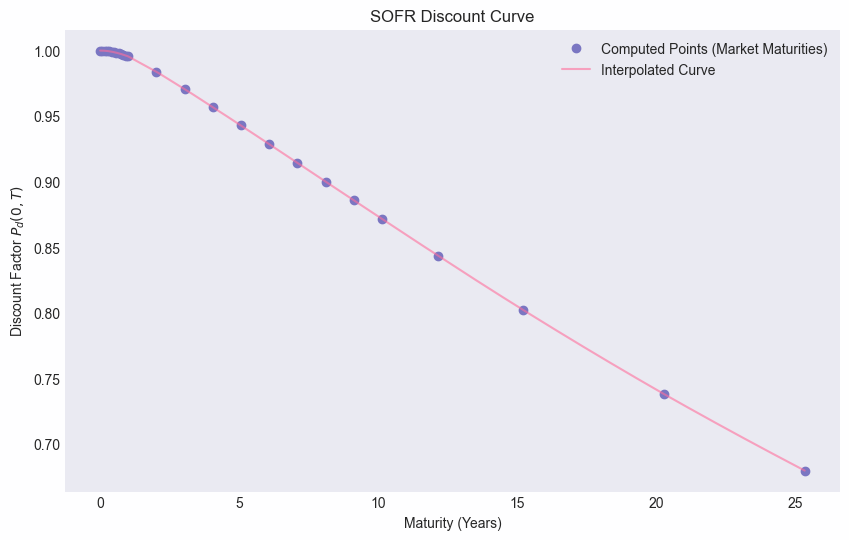

In [33]:
build_sofr_curve(value_date, OIS_code, Quote)

----

#### 2. Build 3M LIBOR curve using SOFR as discounting curve
Specifications:
* Start date = value date (t=0) + 2 bd
* Rolling = Following
* PaymentLag = 0D
* Day Count Convention = Act360
* Calendar = NewYork (US calendar)
* Discounting rate = SOFR

_IRS_ specifications:
* Quarterly floating payment (3M LIBOR) vs annual fix payment

Interpolation:
* Linear interpolation on log DF

Value date:  31.01.22


In [34]:
Instrument_code = ['USD_3M_LIBOR', 'USD_3M_LIBOR_3x6', 'USD_3M_LIBOR_6x9', 'USD_1Y_3M_LIBOR_1Y_FIX', 'USD_2Y_3M_LIBOR_1Y_FIX', 'USD_3Y_3M_LIBOR_1Y_FIX', 'USD_4Y_3M_LIBOR_1Y_FIX', 'USD_5Y_3M_LIBOR_1Y_FIX', 
               'USD_6Y_3M_LIBOR_1Y_FIX', 'USD_7Y_3M_LIBOR_1Y_FIX', 'USD_8Y_3M_LIBOR_1Y_FIX', 'USD_9Y_3M_LIBOR_1Y_FIX', 'USD_10Y_3M_LIBOR_1Y_FIX',
               'USD_12Y_3M_LIBOR_1Y_FIX', 'USD_15Y_3M_LIBOR_1Y_FIX', 'USD_20Y_3M_LIBOR_1Y_FIX', 'USD_25Y_3M_LIBOR_1Y_FIX', 'USD_30Y_3M_LIBOR_1Y_FIX']
LIBORQuote = np.array([0.3, 0.75, 1.1, 0.90, 1.33, 1.53, 1.63, 1.69, 1.73, 1.77, 1.80, 1.82, 1.84, 1.89, 1.93, 1.96, 1.95, 1.92])/100.

Deposit:

$$P_{d,LIBOR}(0, 3M) = \frac{1}{1 + 0.25 L(0, 3M)}$$ 

FRA:
from the lectures: $$PV_0^{FRA} = 0 \quad \Leftrightarrow \quad K = F(t, T, T+\tau)  = \frac{1}{\tau} (\frac{P_d(t, T)}{P(t, T+\tau) - 1})$$

IRS: 
$$
\sum_{i=1}^{N} P_d(0, T_i) \left[\frac{P_d(0, T_{i-1})}{P_d(0, T_i)} - 1\right]  = \sum_{i=1}^{M} P_d(0, {\tilde T_i}) K {\tilde 
\tau_i}.
$$

$\tilde T_i$ and $\tilde \tau_i$ are differ from $T_i, \tau_i$, as fix payments are annual and floating are not

In [35]:
# Generate 3M LIBOR maturities
def generate_LIBOR3_maturities(value_date, Instrument_code, holidays):
    
    start_date = get_adjusted_start_date(value_date, 0)
    maturities = [start_date]
    for code in Instrument_code:
        if "3M_LIBOR" in code:
            if "x" in code:  # Example: 'USD_3M_LIBOR_3x6'
                months_end =  int(code[-1])
                end_date = adjust_date(start_date + pd.DateOffset(months=months_end), holidays)
            elif "Y" in code:  # Example: 'USD_2Y_3M_LIBOR_1Y_FIX'
                years = int(code.split("_")[1][:-1])
                end_date = adjust_date(start_date + pd.DateOffset(years=years), holidays)
            else:  # Default 3M LIBOR
                end_date = adjust_date(start_date + pd.DateOffset(months=3), holidays)
        else:
            raise ValueError(f"Unsupported LIBOR code format: {code}")
        
        maturities.append(end_date)
    return maturities

In [36]:
# Compute discount factors for 3M LIBOR
def compute_LIBOR3_discount_factors(LIBORQuote, maturities):
    P_d_libor = np.ones_like(LIBORQuote)
    yf_libor = np.zeros_like(LIBORQuote)
    
    # Deposit
    yf_libor[1] = year_fraction(maturities[0], maturities[1])
    P_d_libor[1] = 1/(1+ 0.25*LIBORQuote[0])

    #FRA
    #3x6
    yf_libor[2] = year_fraction(maturities[0], maturities[2])
    tau_2 = yf_libor[2] - yf_libor[1]
    P_d_libor[2] = P_d_libor[1]/(LIBORQuote[1]*tau_2) +1

    #6x9
    yf_libor[3] = year_fraction(maturities[0], maturities[3])
    tau_3 = yf_libor[3] - yf_libor[2]
    P_d_libor[3] = P_d_libor[2]/(LIBORQuote[2]*tau_3) +1

    
    #IRS
    for i in range(4, len(LIBORQuote)):
        tau = year_fraction(maturities[0], maturities[i])
        yf_libor[i] = tau
        
        K = LIBORQuote[i-1]
        P_prev = P_d_libor[i - 1]
        tau_i = yf_libor[i] - yf_libor[i-1]
        P_d_libor[i] = P_prev / (1 + K * tau_i)
    
    return yf_libor, P_d_libor

In [37]:
# Plot the LIBOR curve
def plot_LIBOR3_curve(yf_3, P_d_3, interp_times_libor, interp_P_libor):
    plt.figure(figsize=(10, 6))
    plt.plot(yf_3, P_d_3, 'o', label="Computed Points (Market Maturities)")
    plt.plot(interp_times_libor, interp_P_libor, label="Interpolated Curve")
    plt.title("3M LIBOR Discount Curve")
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Discount Factor $P_d(0, T)$")
    plt.legend()
    plt.grid()
    plt.show()

In [38]:
def build_3M_LIBOR_curve(value_date, Instrument_code, LIBORQuote):
    # Step 1: Setup
    holidays = setup_calendar()
    
    # Step 2: Generate maturities
    libor3_maturities = generate_LIBOR3_maturities(value_date, Instrument_code, holidays)
    
    # Step 3: Compute discount factors
    yf_3, P_d_3 = compute_LIBOR3_discount_factors(LIBORQuote, libor3_maturities)
    
    # Step 4: Interpolation
    interp_times_libor, interp_P_libor = log_linear_interpolation(0, yf_3[-1], P_d_3, yf_3)
    
    # Step 5: Plotting
    plot_LIBOR3_curve(yf_3, P_d_3, interp_times_libor, interp_P_libor)


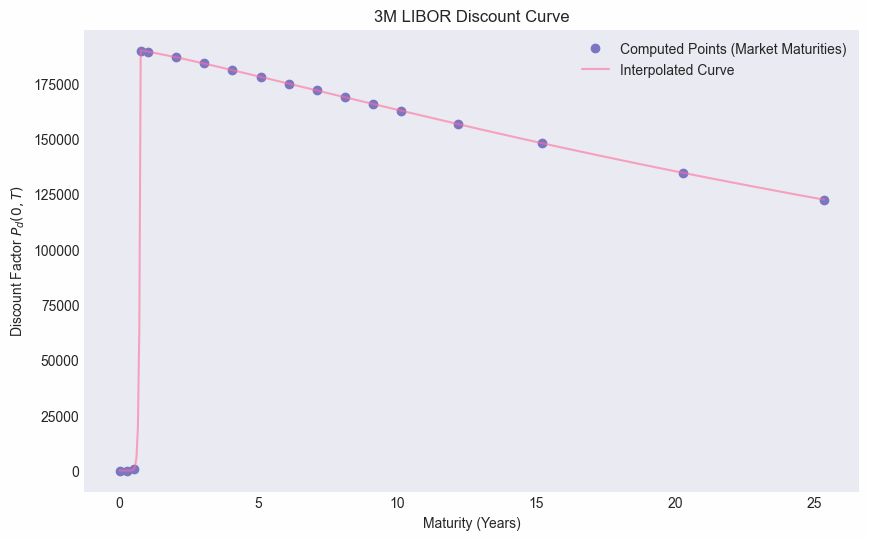

In [39]:
build_3M_LIBOR_curve(value_date, Instrument_code, LIBORQuote)

----

#### 3. Using SOFR and 3M LIBOR curves, build 6M LIBOR curve

Specifications:
* Start date = value date (t=0) + 2 bd
* Rolling = Following 
* PaymentLag = 0D
* Day Count Convention = Act360
* Calendar = NewYork (US calendar)
* Discounting rate = SOFR

_Basis swaps_ specifications:
* Quarterly payment (3M LIBOR + spread) vs semi-annual payment (6M LIBOR)
* Spread is given in basis points

Interpolation:
* Linear interpolation on log DF

Value date:  31.01.22



In [40]:
Instrument_code = ['USD_6M_LIBOR', 'USD_1Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 'USD_18M_3M_LIBOR_Plus_Spread_6M_LIBOR', 
              'USD_2Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 'USD_3Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 'USD_4Y_3M_LIBOR_Plus_Spread_6M_LIBOR',
              'USD_5Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 'USD_6Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 'USD_7Y_3M_LIBOR_Plus_Spread_6M_LIBOR',
              'USD_8Y_3M_LIBOR_Plus_Spread_6M_LIBOR','USD_9Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 'USD_10Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 
              'USD_12Y_3M_LIBOR_Plus_Spread_6M_LIBOR','USD_15Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 'USD_20Y_3M_LIBOR_Plus_Spread_6M_LIBOR', 
              'USD_25Y_3M_LIBOR_Plus_Spread_6M_LIBOR','USD_30Y_3M_LIBOR_Plus_Spread_6M_LIBOR']
Quote = [0,5500, 3.0000, 4.0000, 6.0000, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000, 14.5000, 15.0000, 15.2500, 15.5000, 15.7500, 16.0000, 16.2500, 16.5000]